In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import glob
from pytz import all_timezones

In [2]:
########### BEGIN Building PANDORA DataFrames

In [3]:
# Pandas dataframe from pandora data
npz = np.load('PandoraAltz.npz',allow_pickle=True)
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [4]:
# Filtered data by qflag 0,10
options = [0,10] 
rslt_df = df[df['qflag'].isin(options)] 
#localization of dataframe so that datetime is UTC and not naive
dtimeutc=rslt_df.dtime.dt.tz_localize('Etc/UTC')
dtimelocal=dtimeutc.dt.tz_convert('Etc/GMT+6')
dflocal = rslt_df.assign(dtime=dtimelocal)
tslocal = dflocal.set_index('dtime')
### changing dobson units
tsloc_molcm2=tslocal.assign(ozone=tslocal.ozone*2.6868e16)
## grouping by hour
tslocmean = tsloc_molcm2.ozone.groupby(tslocal.index.hour).mean()
tslocstd=tsloc_molcm2.ozone.groupby(tslocal.index.hour).std()
## grouping by month
tslocmeanmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).mean()
tslocstdmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).std()


In [5]:
########### END Building PANDORA DataFrames
########### BEGIN Building MERRA2 DataFrames

In [6]:
# Pandas DataFrame from MERRA2 data
# data is stored in folders by year, filenames are O3_YYYY_MM_DD_HH.txt
years = np.arange(2012,2020)
date=[]
O3=[]
O3trop=[]
O3strat=[]
#testcount = 0
for year in years:
    merrapath = 'D:\\CCA\\PANDONIA\\O3fromMERRA2\\'+'%i*\\' % (year) + '*.*'
    filelist = glob.glob(merrapath)
    #testcount = testcount + len(filelist)
    #print(testcount)
    for filename in filelist:
        tempdf = pd.read_csv(filename)
        tempdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
        
        ############################ converting pressure to altitude
        tdfa = tempdf[tempdf['modelP'] <= 226.32].assign(modelP=((1.73-np.log(tempdf.modelP/226.32))/0.000157))
        tdfb = tempdf[tempdf['modelP'] > 226.32].assign(modelP=((1-(tempdf.modelP/1013.25)**(1/5.25588))/2.25577e-5))
        tempdf2=tdfa.append(tdfb)
        tempdf2.set_axis(['fixedP','fixedO3','modelAlt','modelO3'], axis=1, inplace=True)
        
        ############################ altitude difference series
        altdiff=tempdf2.modelAlt.diff()
        altdiff=altdiff.replace(altdiff[0],altdiff[1])
        altdiff=-altdiff
        
        ############################ converting altitude to T in degC
        tdfa = tempdf2[tempdf2['modelAlt'] <= 11000].assign(modelAlt=(15.04-0.00649*tempdf2.modelAlt))
        tdfb = tempdf2[tempdf2['modelAlt'] > 11000].assign(modelAlt=-56.46)
        tempdf3=tdfb.append(tdfa)
        tempdf3.set_axis(['fixedP','fixedO3','modelT','modelO3'], axis=1, inplace=True)
        
        ############################ calculating air number density and ozone number density
        nair = tempdf.modelP*100*6.022e23/(8.314463*(tempdf3.modelT+273.15))
        tempdf4 = tempdf2.assign(modelO3=tempdf3.modelO3*nair)
        tempdf5 = tempdf4.assign(modelO3=(tempdf4.modelO3*altdiff)/10000)
        
        ############################ calculating column density
        columnO3=tempdf5.modelO3.sum()
        columnO3trop=tempdf5[tempdf2['modelAlt'] <= 11000].modelO3.sum()
        columnO3strat=tempdf5[tempdf2['modelAlt'] > 11000].modelO3.sum()
        
        ############################ extracting datetime from filename and appending
        time=dt.datetime.strptime(filename[-17:-4],'%Y_%m_%d_%H')
        date.append(time)
        O3.append(columnO3)
        O3trop.append(columnO3trop)
        O3strat.append(columnO3strat)
        
merradf = pd.DataFrame(data={"date": date, "ozone": O3})
merradftrop= pd.DataFrame(data={"date":date,"ozone": O3trop})
merradfstrat= pd.DataFrame(data={"date":date,"ozone": O3strat})


In [17]:
# Monthly MERRA
#total
tsmerra = merradf.set_index('date')
tsmerramm = tsmerra.ozone.resample('M').mean()
tsmerrameanmt = tsmerramm.groupby(tsmerramm.index.month).mean()
tsmerrasm = tsmerra.ozone.resample('M').std()
tsmerrastdmt = tsmerrasm.groupby(tsmerrasm.index.month).std()
#tropospheric
tsmerratrop = merradftrop.set_index('date')
tsmerrammtrop = tsmerratrop.ozone.resample('M').mean()
tsmerrameanmttrop = tsmerrammtrop.groupby(tsmerrammtrop.index.month).mean()
tsmerrasmtrop = tsmerratrop.ozone.resample('M').std()
tsmerrastdmttrop = tsmerrasmtrop.groupby(tsmerrasmtrop.index.month).std()
#stratospheric
tsmerrastrat = merradfstrat.set_index('date')
tsmerrammstrat = tsmerrastrat.ozone.resample('M').mean()
tsmerrameanmtstrat = tsmerrammstrat.groupby(tsmerrammstrat.index.month).mean()
tsmerrasmstrat = tsmerrastrat.ozone.resample('M').std()
tsmerrastdmtstrat = tsmerrasmstrat.groupby(tsmerrasmstrat.index.month).std()

In [8]:
# Hourly MERRA
#total
tsmerra = merradf.set_index('date')
tsmerramean = tsmerra.ozone.groupby(tsmerra.index.hour).mean()
tsmerrastd = tsmerra.ozone.groupby(tsmerra.index.hour).std()
#tropospheric
tsmerratrop = merradftrop.set_index('date')
tsmerrameantrop = tsmerratrop.ozone.groupby(tsmerratrop.index.hour).mean()
tsmerrastdtrop = tsmerratrop.ozone.groupby(tsmerratrop.index.hour).std()
#stratospheric
tsmerrastrat = merradfstrat.set_index('date')
tsmerrameanstrat = tsmerrastrat.ozone.groupby(tsmerrastrat.index.hour).mean()
tsmerrastdstrat = tsmerrastrat.ozone.groupby(tsmerrastrat.index.hour).std()

In [9]:
########### END Building MERRA2 DataFrames
########### BEGIN Building FTIR DataFrames

In [11]:
#total
date=[]
O3=[]
tempdf = pd.read_csv('D:\\CCA\\PANDONIA\\trop-total_O3\\totalO3.txt',sep='\t',header=None)
tempdf.set_axis(['date','ozone'], axis=1, inplace=True)
for ii,ele in enumerate(tempdf.date):
    date.append(dt.datetime.strptime(ele,'%Y-%m-%d:%H'))
    O3.append(tempdf.ozone[ii])
ftirdf = pd.DataFrame(data={"date": date, "ozone": O3})
#tropospheric
date=[]
O3trop=[]
tempdf = pd.read_csv('D:\\CCA\\PANDONIA\\trop-total_O3\\tropO3.txt',sep='\t',header=None)
tempdf.set_axis(['date','ozone'], axis=1, inplace=True)
for ii,ele in enumerate(tempdf.date):
    date.append(dt.datetime.strptime(ele,'%Y-%m-%d:%H'))
    O3trop.append(tempdf.ozone[ii])
ftirdftrop = pd.DataFrame(data={"date": date, "ozone": O3trop})

In [21]:
#Hourly FTIR
#total
tsftir = ftirdf.set_index('date')
tsftirmean = tsftir.ozone.groupby(tsftir.index.hour).mean()
tsftirstd = tsftir.ozone.groupby(tsftir.index.hour).std()
#tropospheric
tsftirtrop = ftirdftrop.set_index('date')
tsftirmeantrop = tsftirtrop.ozone.groupby(tsftir.index.hour).mean()
tsftirstdtrop = tsftirtrop.ozone.groupby(tsftir.index.hour).std()
#Monthly FTIR
#total
tsftirmeanmt = tsftir.ozone.groupby(tsftir.index.month).mean()
tsftirstdmt = tsftir.ozone.groupby(tsftir.index.month).std()
#tropospheric
tsftirmeanmttrop = tsftirtrop.ozone.groupby(tsftir.index.month).mean()
tsftirstdmttrop = tsftirtrop.ozone.groupby(tsftir.index.month).std()

In [13]:
########### END Building FTIR DataFrames

In [14]:
## simple plotting with error - DEPRECATED
#ax = tslocmeanmt.plot(figsize=(10,6),title='Ozone yearly profile',ylabel='molecule/cm$^2$',yerr=tslocstdmt,capsize=4,fontsize=12)
#tsmerramm2.plot(figsize=(10,6),xlabel='Month',yerr=tsmerrastdmt,capsize=4,fontsize=12)

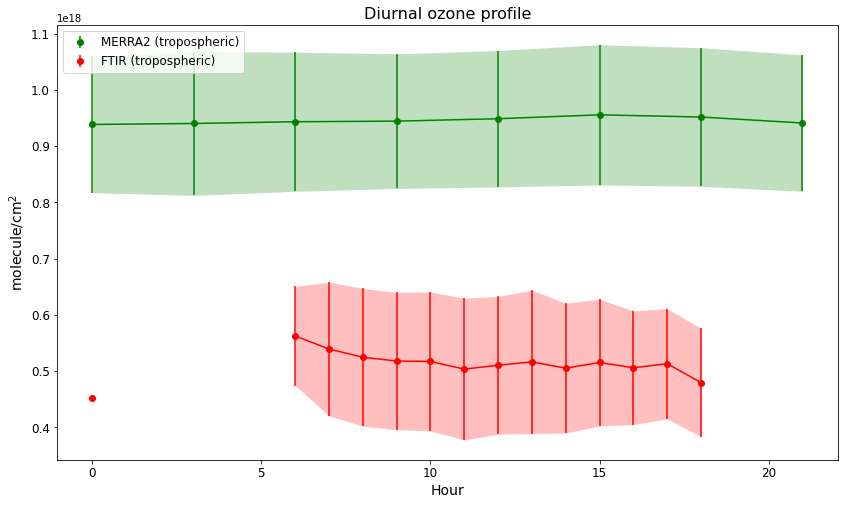

In [29]:
## pyplot plotting
# PANDONIA = loc, MERRA2 = merra, FTIR = ftir
# varname format = ts + source + mean/std + hourly(none)/monthly(mt) + total(none)/trop/strat 
# e.g. tsmerrameanmttrop

# Variable definition
x1 = tslocmean.index
y1 = tslocmean
err1 = tslocstd
x2 = tsmerrameantrop.index
y2 = tsmerrameantrop
err2 = tsmerrastdtrop
x3 = tsftirmeantrop.index 
y3 = tsftirmeantrop
err3 = tsftirstdtrop

### INITIALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))

## line and stdev
#ax1.plot(x1, y1, '-b')
#ax1.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
ax1.plot(x2, y2, '-g')
ax1.fill_between(x2, y2-err2, y2+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
ax1.plot(x3, y3, '-r')
ax1.fill_between(x3, y3-err3, y3+err3,alpha=.25, edgecolor='#3F7F4C', facecolor='r',linewidth=0)

## LABEL, marker and errorbar
#ax1.errorbar(x1, y1, yerr=err1, fmt='bo', label='Pandonia Altzomoni (total)')
ax1.errorbar(x2, y2, yerr=err2, fmt='go', label='MERRA2 (tropospheric)')
ax1.errorbar(x3, y3, yerr=err3, fmt='ro', label='FTIR (tropospheric)')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax1.set_xlabel('Hour',size=14)
ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_title("Diurnal ozone profile",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

## SAVEFIG
#plt.savefig('D:\\CCA\\PANDONIA\\diurnalO3PanAltzMERRA.png')

In [ ]:
################## TESTING AFTER THIS LINE

In [ ]:
testdf = pd.read_csv('D:\\CCA\\PANDONIA\\trop-total_O3\\tropO3.txt',sep='\t',header=None)
testdf.set_axis(['date','tropO3'], axis=1, inplace=True)
testdf

In [ ]:
dt.datetime.strptime(testdf.date[74061],'%Y-%m-%d:%H')

In [ ]:
len(testdf.date)

In [ ]:
for ii,ele in enumerate(testdf.date):
    if (ii%10000)==0:
        print(dt.datetime.strptime(ele,'%Y-%m-%d:%H'))
        print(testdf.tropO3[ii])

In [ ]:
############################# PandoraAltz, PandoraAltzNO2, FTIRAltzTotalO3-LITE

In [11]:
#### Pandora needs qflag filtering
#dtime, ozone
npz = np.load('PandoraAltz.npz',allow_pickle=True)
dfpano3= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

#dtime, no2
npz = np.load('PandoraAltzNO2.npz',allow_pickle=True)
dfpanno2= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

options = [0,10] 
qf_dfpano3 = dfpano3[dfpano3['qflag'].isin(options)] 
qf_dfpanno2 = dfpanno2[dfpanno2['qflag'].isin(options)] 

########
#time, o3column
npz = np.load('FTIRAltzTotalO3-LITE.npz',allow_pickle=True)
dfftiro3= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [15]:
#timeseries
ftirts=dfftiro3.set_index('time')
pano3ts=qf_dfpano3.set_index('dtime')
panno2ts=qf_dfpanno2.set_index('dtime')

In [18]:
panno2ts

,no2,uncty,no2massf,diffcorr,qflag,sum2iDQ1,sum2iDQ2
dtime,,,,,,,
2019-02-01 15:39:12.000,0.063686,0.001408,1.929,0.0,0,0.0,0.0
2019-02-01 15:40:40.000,0.065188,0.001530,1.914,0.0,0,0.0,0.0
2019-02-01 15:42:05.000,0.064987,0.001842,1.899,0.0,0,0.0,0.0
2019-02-01 15:43:31.000,0.063933,0.004026,1.884,0.0,0,0.0,0.0
2019-02-01 15:44:56.000,0.066786,0.001539,1.870,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2021-08-23 16:13:32.400,0.094621,0.002470,1.227,0.0,10,0.0,0.0
2021-08-23 16:13:38.500,0.102320,0.002492,1.227,0.0,10,0.0,0.0
2021-08-23 16:13:44.500,0.100510,0.002673,1.227,0.0,10,0.0,0.0


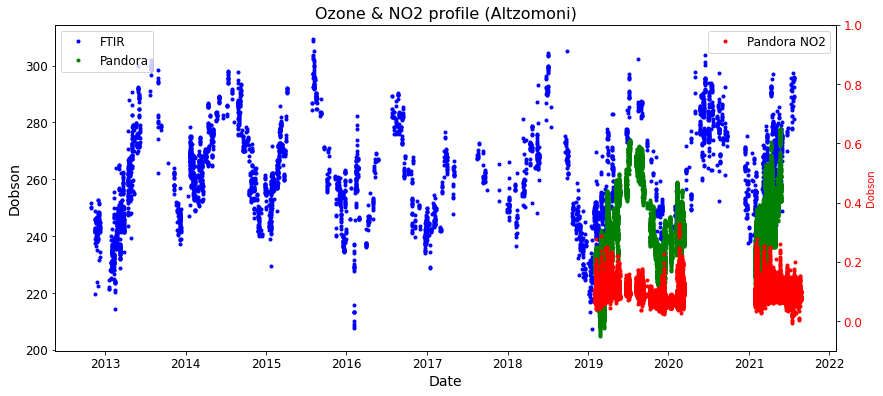

In [33]:
## pyplot plotting 

f, ax0 = plt.subplots(figsize=(14,6))
ax0.plot(ftirts.index, ftirts['o3column'], '.b', label='FTIR')
ax0.plot(pano3ts.index, pano3ts['ozone'], '.g', label='Pandora')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone & NO2 profile (Altzomoni)",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)

ax2 = ax0.twinx() 
  
color = 'r'
ax2.set_ylim([-.1,1])
ax2.set_ylabel('Dobson', color = color) 
ax2.plot(panno2ts.index, panno2ts['no2'], '.r', label='Pandora NO2') 
ax2.tick_params(axis ='y',labelsize=12, labelcolor = color) 
ax2.legend(fontsize=12, loc='upper right')